# Thesis - CNN and its Architecture for the Classification of Malware 


The code below adhears to the Apache 2 license.

**This Paper is broken down into Sections:**

0 - Data Preprocessing

> Please note Data Preprocessing section required me to reupload the dataset as Kaggle is a read only file system. The script made on my machine for file deletion can be found under the new dataset imported and is called FileDeletion.py
> 

1 - Building a Basic CNN for Malware Classification


2 - Editing basic CNNs Convolutional layers


3 - Using Pretrained Models for Malware Classification

References: Code references made throughout the paper, is included in the end (throughout the code I have also made references were explicitly needed)

In [99]:
#Import Statements
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense,MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Conv1D
from keras.utils import plot_model


import tensorflow as tf
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

#improt metrics to show results of the model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score

#3.3 Section for models:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50



# Data Preprocessing

**Import The Data Set**

Here we will be importing the dataset that will be used for the Training, Validation and Testing of our CNN models.

For this we are using the Malimg Dataset provided from Kaggle. As will seen below this Dataset is unbalanced with both Allaple families being overrepresented

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dataset = "../input/malimg/malimg_dataset/train"
val = "../input/malimg/malimg_dataset/val"
test = "../input/malimg/malimg_dataset/test"

training = ImageDataGenerator().flow_from_directory(directory=training_dataset, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')
validation = ImageDataGenerator().flow_from_directory(directory=val, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')
testing= ImageDataGenerator().flow_from_directory(directory=test, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')

print(training.class_indices.keys())

Found 7459 images belonging to 25 classes.
Found 923 images belonging to 25 classes.
Found 957 images belonging to 25 classes.
dict_keys(['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A'])


The Ratio of the above data is split in 8:1:1 (Training:Validiation:Testing) for the dataset with 25 classes

**Visualising the pre-balanced Data**

Now we will perform visulisation of the current data without any pre-processing or dataaugementation/balancing

> Inspritation for the plotting of data was adapted from: https://www.kaggle.com/code/gauravpendharkar/malware-classification?scriptVersionId=124040908&cellId=5, under the Apache 2 License

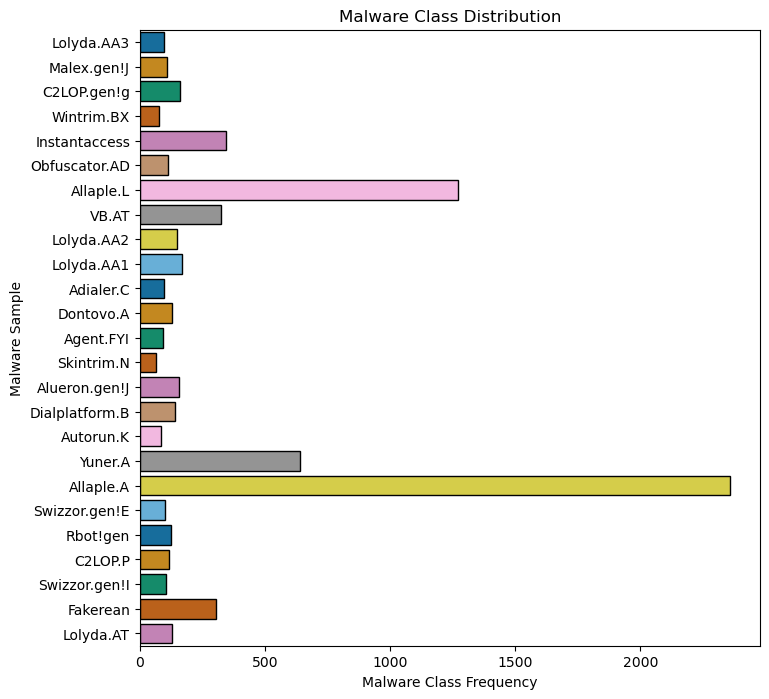

In [3]:
def compute_class_distribution(data_dir):
    class_distribution = {}
    for malware_type in os.listdir(data_dir):
        malware_img_dir = os.path.join(data_dir, malware_type)
        class_distribution[malware_type] = len(os.listdir(malware_img_dir))
    return class_distribution

def plot_class_distribution(data_dir):
    class_distribution = compute_class_distribution(data_dir)
    malware_classes = list(class_distribution.keys())
    malware_class_frequency = list(class_distribution.values())
    color_palette = sns.color_palette("colorblind")
    plt.figure(figsize=(8, 8))
    sns.barplot(y=malware_classes,
                x=malware_class_frequency,
                palette=color_palette,
                edgecolor="black",
                orient='h')
    plt.title("Malware Class Distribution")
    plt.xlabel("Malware Class Frequency")
    plt.ylabel("Malware Sample")
    plt.show()

plot_class_distribution(training_dataset)

**Balancing the Data**

To Balance the Data we will be undersampling the Allaple.A and Allaple.B families. We will undersample these to the average number of files within each family (excluding the Allaple families). This will allow us to address the issue of overfitting our model. We will perform this across all three datasets as this will ensure that there is the 8:1:1 data split that we had at the start. 


First we will take the count as shown in function below in kaggle natively.

For the deletion of files I will run the script on my own machine as Kaggle is a read only file system and will reupload the data into kaggle as BalancedM-a-l-i-m-g, and the script will be called FileDeletion.py. 

**Count**

Inspiration for function in file counting was from: https://stackoverflow.com/a/16910392

In [16]:
def count_files(directory):
    file_count = len(os.listdir(directory))
    return file_count

def count_files_in_subfolders(main_directory):
    subfolders = os.listdir(main_directory)
    file_counts = {}

    for folder in subfolders:
        folder_path = os.path.join(main_directory, folder)
        if os.path.isdir(folder_path):
            file_count = count_files(folder_path)
            file_counts[folder] = file_count

    return file_counts

# Example usage
main_directory = '../input/malimg/malimg_dataset/train'
file_counts = count_files_in_subfolders(main_directory)
file_counts_val = count_files_in_subfolders('../input/malimg/malimg_dataset/val')
file_counts_test = count_files_in_subfolders('../input/malimg/malimg_dataset/test')

# Print the file counts for each subfolder
for folder, count in file_counts.items():
    print(f"Number of files in {folder}: {count}")

Number of files in Lolyda.AA3: 98
Number of files in Malex.gen!J: 108
Number of files in C2LOP.gen!g: 160
Number of files in Wintrim.BX: 77
Number of files in Instantaccess: 344
Number of files in Obfuscator.AD: 113
Number of files in Allaple.L: 1272
Number of files in VB.AT: 326
Number of files in Lolyda.AA2: 147
Number of files in Lolyda.AA1: 170
Number of files in Adialer.C: 97
Number of files in Dontovo.A: 129
Number of files in Agent.FYI: 92
Number of files in Skintrim.N: 64
Number of files in Alueron.gen!J: 158
Number of files in Dialplatform.B: 141
Number of files in Autorun.K: 84
Number of files in Yuner.A: 640
Number of files in Allaple.A: 2359
Number of files in Swizzor.gen!E: 102
Number of files in Rbot!gen: 126
Number of files in C2LOP.P: 116
Number of files in Swizzor.gen!I: 105
Number of files in Fakerean: 304
Number of files in Lolyda.AT: 127


In [5]:
def count_files_in_subfolders(main_directory, exclude_folders):
    subfolders = os.listdir(main_directory)
    file_counts = []

    for folder in subfolders:
        if folder in exclude_folders:
            continue

        folder_path = os.path.join(main_directory, folder)
        if os.path.isdir(folder_path):
            file_count = count_files(folder_path)
            file_counts.append(file_count)

    return file_counts

def average(file_counter):
    return sum(file_counter) / len(file_counter)


main_directory = '../input/malimg/malimg_dataset/train'
exclude_folders = ['Allaple.A', 'Allaple.L']
file_counts_training = count_files_in_subfolders(main_directory, exclude_folders)
file_counts_validation = count_files_in_subfolders('../input/malimg/malimg_dataset/val', exclude_folders)
file_counts_testing = count_files_in_subfolders('../input/malimg/malimg_dataset/test', exclude_folders)

training_average = average(file_counts_training)
validation_average = average(file_counts_validation)
testing_average = average(file_counts_testing)

print(f"Average number of files Training per folder without Allaple Families is: {training_average}")
print(f"Average number of files Validatiom per folder without Allaple Families is: {validation_average}")
print(f"Average number of files Testing per folder without Allaple Families is: {testing_average}")


Average number of files Training per folder without Allaple Families is: 166.43478260869566
Average number of files Validatiom per folder without Allaple Families is: 20.434782608695652
Average number of files Testing per folder without Allaple Families is: 21.782608695652176


**Files to Delete Script**

> NB: not executed fully on system as Kaggle is a read only data system. This is shown with the error below when we try to delete a random file from the AllapaleL system.
> 
I have downloaded the dataset onto my machine and ran the deletion of files and reuploaded them. note I generated a output file so that you can view the files I deleted from each dataset.

In [8]:

#This is the actual code used in my system and is uploaded as: balancedm-a-l-i-m-g, note I didn't take the number as math floors and show it this way as this was on my local machine

#The FileDeletion.py script was the script that is used to complete the balacning of the data

# Count taken manually from Kaggle numbers of files _to_delete = Total_files - average_number
training_files_to_delete_A = 2193 # 2359 - 166
training_files_to_delete_L = 1106 # 1272 - 166

validation_files_to_delete_A = 274 #294 - 20
validation_files_to_delete_L = 139 #159 - 20

testing_files_to_delete_A = 275 #296-21
testing_files_to_delete_L = 139 #160-21

print(os.listdir("../input/balancedm-a-l-i-m-g/malimg_dataset"))

['Validation-Allaple.A-deletion.txt', 'Validation-Allaple.L-deletion.txt', 'Testing-Allaple.A-deletion.txt', 'Training-Allaple.A-deletion.txt', 'Training-Allaple.L-deletion.txt', 'val', 'Testing-Allaple.L-deletion.txt', 'test', 'train', 'FileDeletion.py']


# Re-initalise Data with Balanced Dataset
Now that we have balanced the dataset we will need to reinitalise the dataset.

Found 4160 images belonging to 25 classes.
Found 510 images belonging to 25 classes.
Found 543 images belonging to 25 classes.


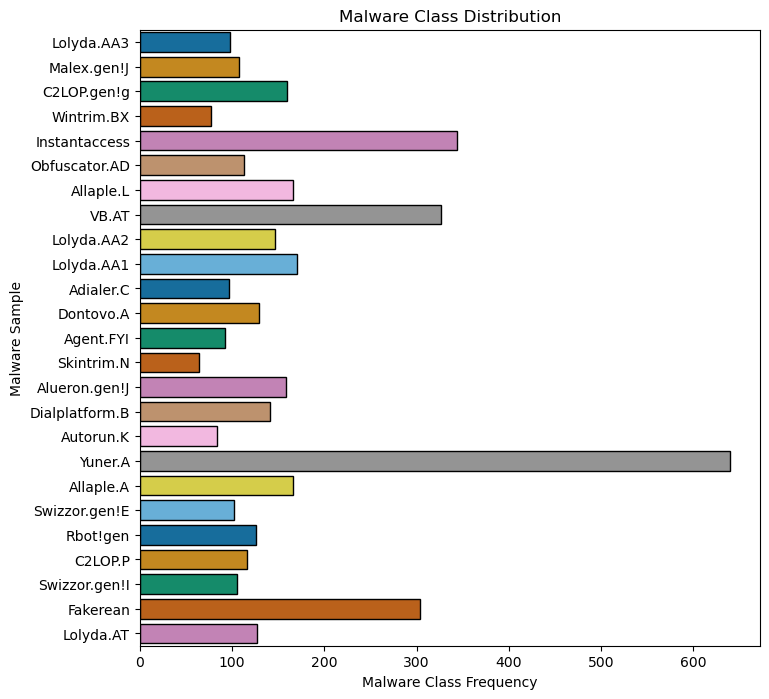

In [19]:
training_dataset = "../input/balancedm-a-l-i-m-g/malimg_dataset/train"
val = "../input/balancedm-a-l-i-m-g/malimg_dataset/val"
test = "../input/balancedm-a-l-i-m-g/malimg_dataset/test"

training = ImageDataGenerator().flow_from_directory(directory=training_dataset, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')
validation = ImageDataGenerator().flow_from_directory(directory=val, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')
testing= ImageDataGenerator().flow_from_directory(directory=test, target_size=(128,128), batch_size=64, color_mode="grayscale", class_mode ='categorical')

plot_class_distribution(training_dataset)


In [20]:
#Helper Function that is used to create a numpy array that will be critical later on for the testing of data, to create result models and allow us to compare results, in confusion matrix
#this function was created as many other used train_test_split to get a numpy array our data is already split and we do not do this
def create_DataArray(dataset):
    
    x = []
    y = []
    
    for i in range(len(dataset)):
        x_batch, y_batch = next(dataset)
        x.append(x_batch)
        y.append(y_batch)
        
    x_value = np.concatenate(x, axis=0)
    y_value = np.concatenate(y, axis=0)
    
    return x_value, y_value



# 3.1 Building a basic CNN Model for classification

**Basic Model Architecture**

The initial idea for the base CNN architecture was adapted from https://www.kaggle.com/code/mhmdsyed/malware-cnn-image-classification/notebook, please note in the meantime it has significantly changed as I learnt more about CNNs and how to use Keras.

As explained in my thesis the structure has been kept to a BatchNormalization layer after every convolutional layer and a maxpooling and dropout layer for every second convolution layer 

In [21]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(128, 128, 1), activation='relu',
                 padding='same'))

model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), 
                 activation='relu', padding='same'))

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(25, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

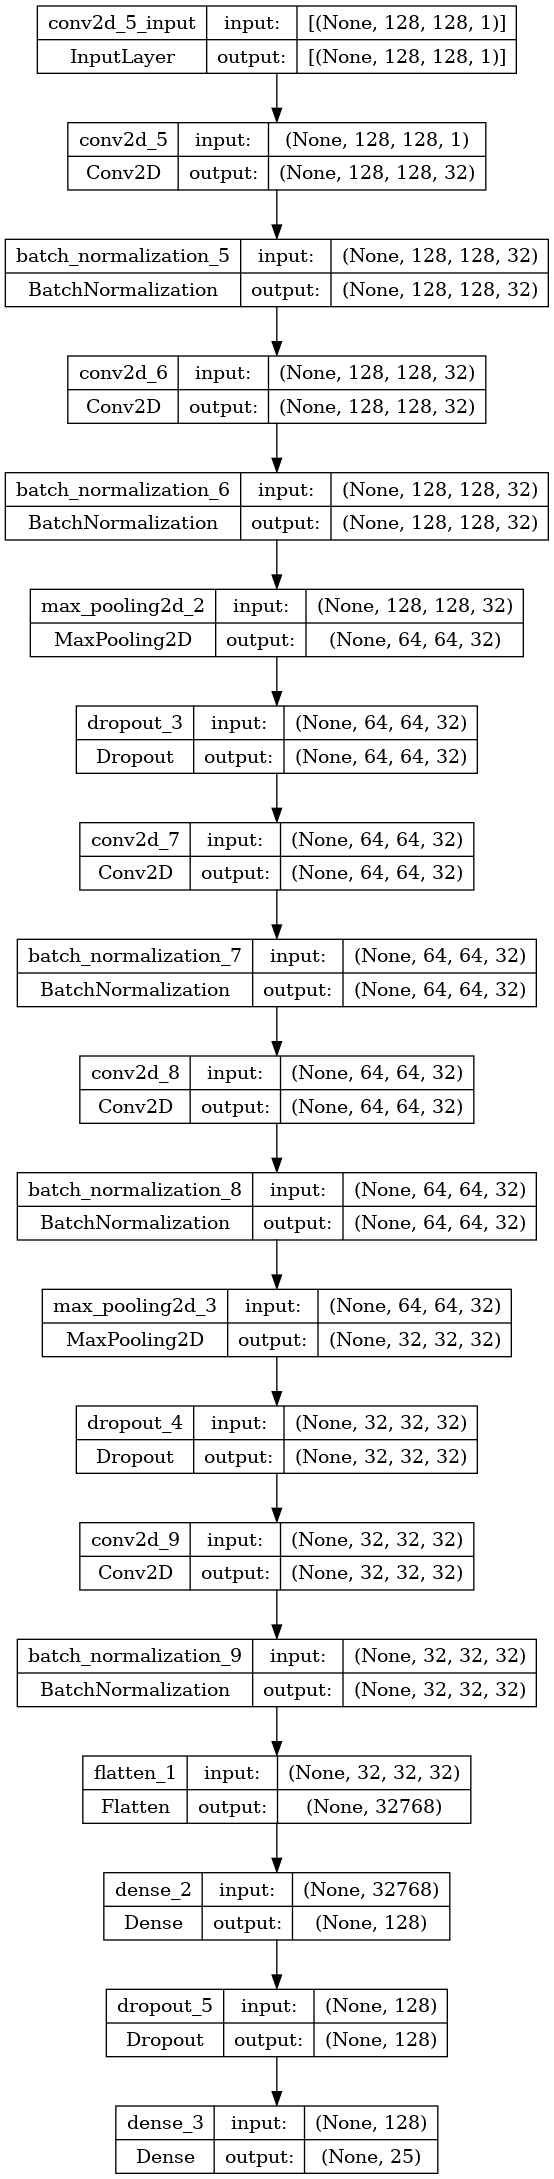

In [100]:
plot_model(model, to_file='model_basicCNN.png', show_shapes=True, show_layer_names=True)

**Compile and Fit the Model on Training Data, with use of Validation Data**

In [23]:
model.compile(keras.optimizers.Adam(lr=0.001) ,loss='categorical_crossentropy', metrics=['accuracy'])


#helper callback function which was also adapted from https://www.kaggle.com/code/mhmdsyed/malware-cnn-image-classification/notebook. 
def callbacks(filename):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,
                                                    monitor='val_accuracy',
                                                    verbose=1,
                                                    save_best_only=True)
    call_backs = [early_stop, checkpoint]
    return call_backs

basic_Cnn_callbacks = callbacks("basic_CNN")

In [24]:
#we train the function with fit. We use validation whilst training the track how the model has 'learned' the new weights to ensure we are not overfitting.
#we also define the epoches and the batch size(which need to be same as the flowfromdirectory function we called to intialise data)
Basic_CNN = model.fit(training, validation_data=validation, 
                    epochs=10, batch_size=64, callbacks=basic_Cnn_callbacks)



Epoch 1/10


2023-06-14 11:35:39.961446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.8262
Epoch 1: val_accuracy improved from -inf to 0.10196, saving model to basic_CNN
65/65 [==============================] - 73s 873ms/step - loss: 0.6980 - accuracy: 0.8262 - val_loss: 6.3468 - val_accuracy: 0.1020
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9478
Epoch 2: val_accuracy improved from 0.10196 to 0.81176, saving model to basic_CNN
65/65 [==============================] - 24s 373ms/step - loss: 0.1629 - accuracy: 0.9478 - val_loss: 0.7087 - val_accuracy: 0.8118
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9748
Epoch 3: val_accuracy did not improve from 0.81176
65/65 [==============================] - 19s 287ms/step - loss: 0.0861 - accuracy: 0.9748 - val_loss: 0.9299 - val_accuracy: 0.7549
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9851
Epoch 4: val_accuracy did n

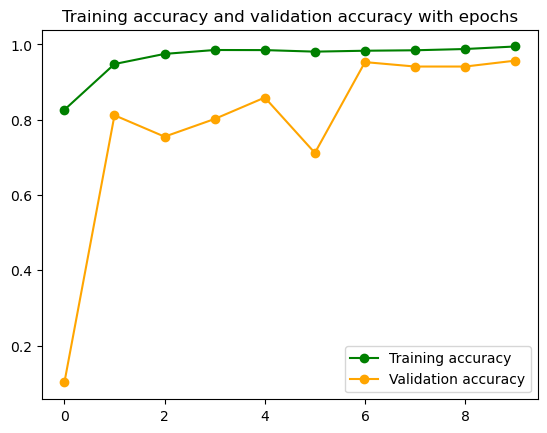

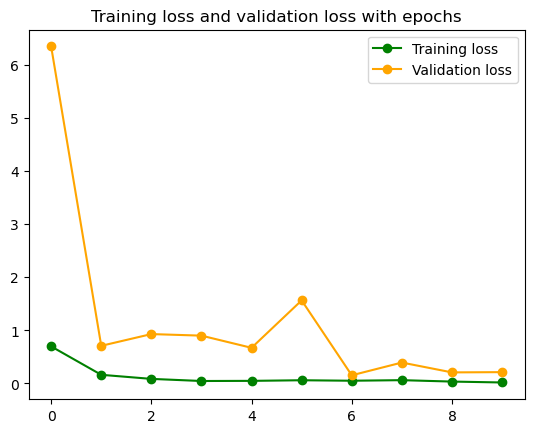

In [25]:
#code section adapted from mhmdsyed, to represent results
def plot_loss_and_accuracy_training(model):
    plt.title('Training accuracy and validation accuracy with epochs',
              fontsize=12)

    plt.plot(model.history['accuracy'],
             marker='o',
             color="green",
             label="Training accuracy")

    plt.plot(model.history['val_accuracy'],
             marker='o',
             color="orange",
             label="Validation accuracy")

    plt.legend()
    plt.show()

    # plot loss function for train and validation.
    plt.title('Training loss and validation loss with epochs', 
              fontsize=12)

    plt.plot(model.history['loss'],
             marker='o',
             color="green",
             label="Training loss")

    plt.plot(model.history['val_loss'],
             marker='o',
             color="orange", 
             label="Validation loss")

    plt.legend()
    plt.show()
    
plot_loss_and_accuracy_training(Basic_CNN)

Now that we have Captured the patterns using fit, we will now work to evaluate this model on the actual test Data

# Predictions

In [26]:
# Helper Function from start so we can visulise our data. 
x_test, y_test = create_DataArray(testing)

prediction = model.predict(x_test, batch_size=64, verbose=2)

test_loss, test_acc = model.evaluate(testing, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

9/9 - 1s - 756ms/epoch - 84ms/step
50/50 [==============================] - 2s 40ms/step - loss: 0.0552 - accuracy: 0.9853
Test Accuracy: 98.53 %
Test Loss: 0.05520012229681015


In [39]:
rounded_predictions = np.argmax(prediction, axis=1)
#rounded_predictions

In [40]:
actual_test_values = np.argmax(y_test, axis=1)
#actual_test_values

# **Visualisng the results**

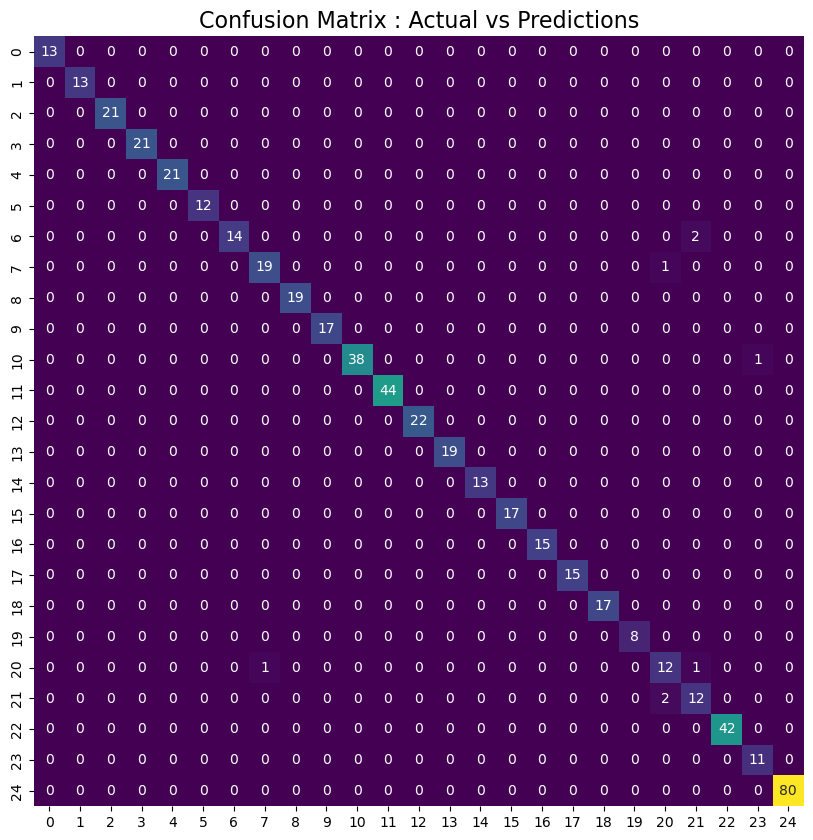

In [41]:
def plot_confusion(actual_values, predictions):
    cm = confusion_matrix(actual_values, predictions)

    plt.figure(figsize=(10,10))
    plt.title("Confusion Matrix : Actual vs Predictions",fontsize=16)
    sns.heatmap(cm, fmt='d', cmap='viridis', annot = True, square=True, cbar=False)
    plt.show()
    
plot_confusion(actual_test_values, rounded_predictions)

# Classification Report

Had inspiration for this from: https://www.kaggle.com/code/gauravpendharkar/malware-classification#Model-Exploration-on-the-three-datasets

In [52]:
class_names = training.class_indices.keys()

print(classification_report(actual_test_values, rounded_predictions, target_names=class_names))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       1.00      1.00      1.00        13
     Allaple.A       1.00      1.00      1.00        21
     Allaple.L       1.00      1.00      1.00        21
 Alueron.gen!J       1.00      1.00      1.00        21
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       1.00      0.88      0.93        16
   C2LOP.gen!g       0.95      0.95      0.95        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       1.00      1.00      1.00        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       1.00      1.00      1.00        22
    Lolyda.AA2       1.00      1.00      1.00        19
    Lolyda.AA3       1.00      1.00      1.00        13
     Lolyda.AT       1.00      1.00      1.00        17
   Malex.gen!J       1.00      1.00      1.00  

# Changing Basic CNN Architecture

Now we will be changing the basic architectures network.

1 --> We will add 2 extra convolutional layers (meaning 2 extra batch normalizations and one extra maxpooling and dropout layer aswell).

2 --> We will remove 2 convolutional layers (meaning 2 less batch normalizations and one less maxpooling and dropout layers).

**1**

In [54]:
extra_model = Sequential()

# Convolutional Layer
extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(128, 128, 1), activation='relu',
                 padding='same'))

extra_model.add(BatchNormalization())
extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())

extra_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

extra_model.add(Dropout(0.25))

extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())
extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())
extra_model.add(MaxPool2D(pool_size=(2, 2)))
extra_model.add(Dropout(0.25))

extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())

extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())
extra_model.add(MaxPool2D(pool_size=(2, 2)))
extra_model.add(Dropout(0.25))

extra_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', padding='same'))

extra_model.add(BatchNormalization())

extra_model.add(Flatten())
extra_model.add(Dense(128, activation='relu'))
extra_model.add(Dropout(0.25))
extra_model.add(Dense(25, activation='softmax'))
extra_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_17 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

In [56]:
extra_model.compile(keras.optimizers.Adam(lr=0.001) ,loss='categorical_crossentropy', metrics=['accuracy'])

more_layers_callbacks = callbacks("more_CNN")

In [57]:
More_Layers_CNN = extra_model.fit(training, validation_data=validation, 
                    epochs=10, batch_size=64, callbacks=more_layers_callbacks)

Epoch 1/10


2023-06-14 12:02:11.540454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.8240 - accuracy: 0.7709
Epoch 1: val_accuracy improved from -inf to 0.07843, saving model to more_CNN
65/65 [==============================] - 36s 430ms/step - loss: 0.8240 - accuracy: 0.7709 - val_loss: 5.3469 - val_accuracy: 0.0784
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9185
Epoch 2: val_accuracy improved from 0.07843 to 0.72157, saving model to more_CNN
65/65 [==============================] - 25s 377ms/step - loss: 0.2534 - accuracy: 0.9185 - val_loss: 0.9900 - val_accuracy: 0.7216
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9474
Epoch 3: val_accuracy improved from 0.72157 to 0.89020, saving model to more_CNN
65/65 [==============================] - 24s 377ms/step - loss: 0.1655 - accuracy: 0.9474 - val_loss: 0.3402 - val_accuracy: 0.8902
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9526

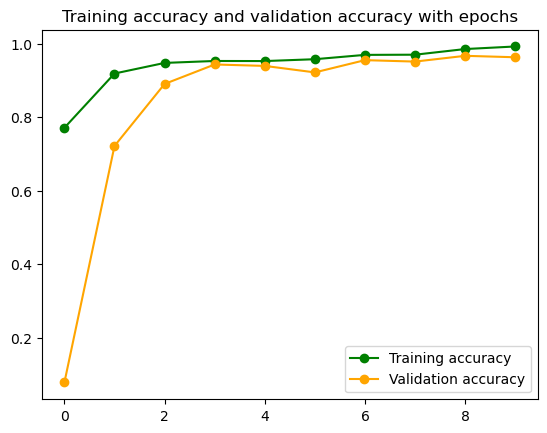

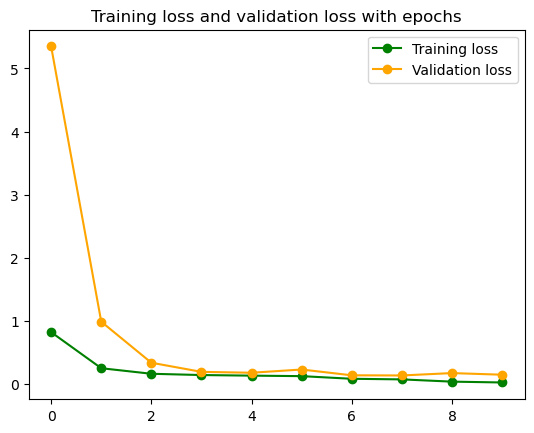

In [58]:
plot_loss_and_accuracy_training(More_Layers_CNN)

In [63]:
prediction_extra = extra_model.predict(x_test, batch_size=64, verbose=2)

test_loss, test_acc = extra_model.evaluate(testing, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)


9/9 - 0s - 216ms/epoch - 24ms/step
50/50 [==============================] - 2s 42ms/step - loss: 0.1104 - accuracy: 0.9705
Test Accuracy: 97.05 %
Test Loss: 0.11043529212474823


In [64]:
rounded_predictions_extra = np.argmax(prediction_extra, axis=1)

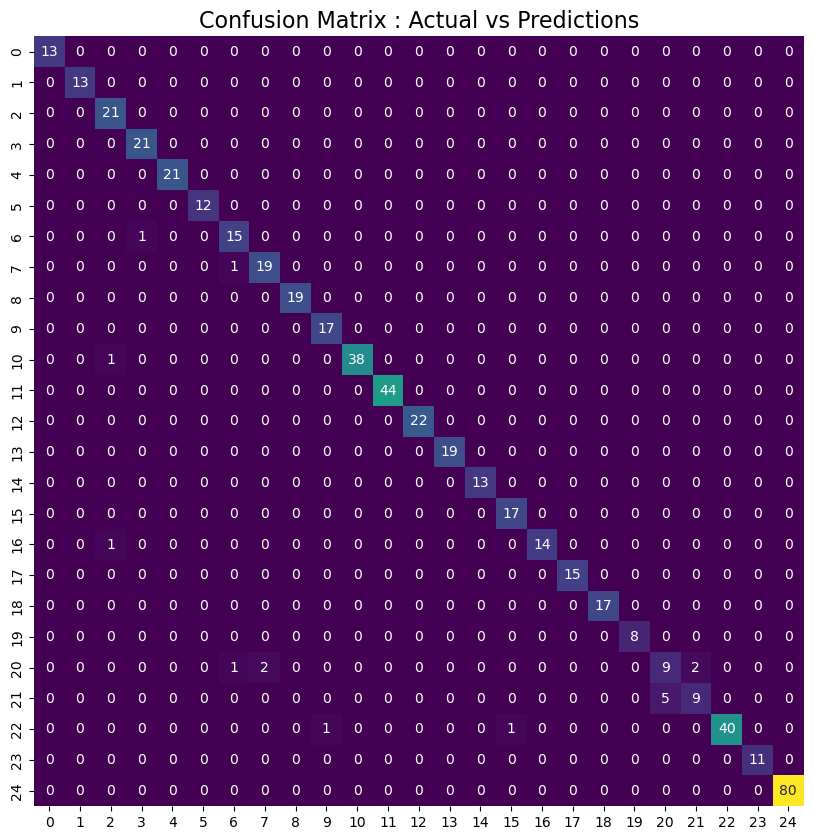

In [65]:
plot_confusion(actual_test_values, rounded_predictions_extra)

In [66]:
print(classification_report(actual_test_values, rounded_predictions_extra, target_names=class_names))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       1.00      1.00      1.00        13
     Allaple.A       0.91      1.00      0.95        21
     Allaple.L       0.95      1.00      0.98        21
 Alueron.gen!J       1.00      1.00      1.00        21
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       0.88      0.94      0.91        16
   C2LOP.gen!g       0.90      0.95      0.93        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       0.94      1.00      0.97        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       1.00      1.00      1.00        22
    Lolyda.AA2       1.00      1.00      1.00        19
    Lolyda.AA3       1.00      1.00      1.00        13
     Lolyda.AT       0.94      1.00      0.97        17
   Malex.gen!J       1.00      0.93      0.97  

**2**

Removing a two convolutional layers

In [67]:
less_model = Sequential()

less_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(128, 128, 1), activation='relu',
                 padding='same'))
 
less_model.add(BatchNormalization())
less_model.add(Conv2D(filters=32, kernel_size=(3,3), 
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

less_model.add(BatchNormalization())

less_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

less_model.add(Dropout(0.25))

less_model.add(Conv2D(filters=32, kernel_size=(3,3),
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

less_model.add(BatchNormalization())

less_model.add(Flatten())
less_model.add(Dense(128, activation='relu'))
less_model.add(Dropout(0.25))
less_model.add(Dense(25, activation='softmax'))
less_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_24 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_25 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                      

In [68]:
less_model.compile(keras.optimizers.Adam(lr=0.001) ,loss='categorical_crossentropy', metrics=['accuracy'])

less_layers_callbacks = callbacks("less_CNN")

In [69]:
Less_Layers_CNN = less_model.fit(training, validation_data=validation, 
                    epochs=10, batch_size=64, callbacks=less_layers_callbacks)

Epoch 1/10


2023-06-14 12:10:59.727646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 1.5745 - accuracy: 0.8495
Epoch 1: val_accuracy improved from -inf to 0.60980, saving model to less_CNN
65/65 [==============================] - 27s 352ms/step - loss: 1.5745 - accuracy: 0.8495 - val_loss: 13.4323 - val_accuracy: 0.6098
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9784
Epoch 2: val_accuracy improved from 0.60980 to 0.74510, saving model to less_CNN
65/65 [==============================] - 23s 353ms/step - loss: 0.0851 - accuracy: 0.9784 - val_loss: 3.1176 - val_accuracy: 0.7451
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9921
Epoch 3: val_accuracy improved from 0.74510 to 0.92157, saving model to less_CNN
65/65 [==============================] - 22s 343ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 0.4224 - val_accuracy: 0.9216
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.993

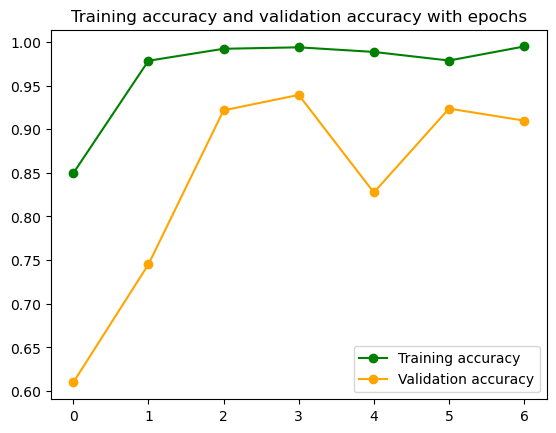

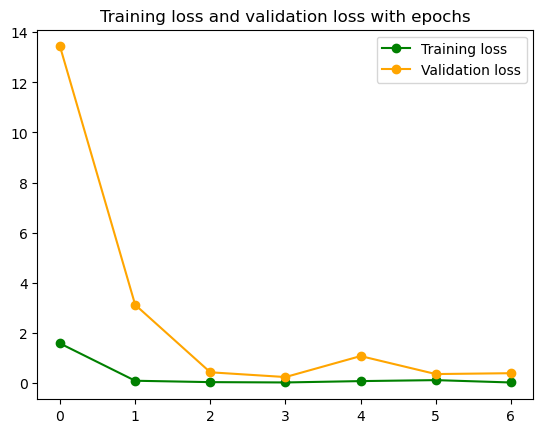

In [70]:
plot_loss_and_accuracy_training(Less_Layers_CNN)

In [72]:
prediction_less = less_model.predict(x_test, batch_size=64, verbose=2)

test_loss, test_acc = less_model.evaluate(testing, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

9/9 - 0s - 194ms/epoch - 22ms/step
50/50 [==============================] - 2s 38ms/step - loss: 0.1994 - accuracy: 0.9466
Test Accuracy: 94.66 %
Test Loss: 0.19939537346363068


In [73]:
rounded_predictions_less = np.argmax(prediction_less, axis=1)


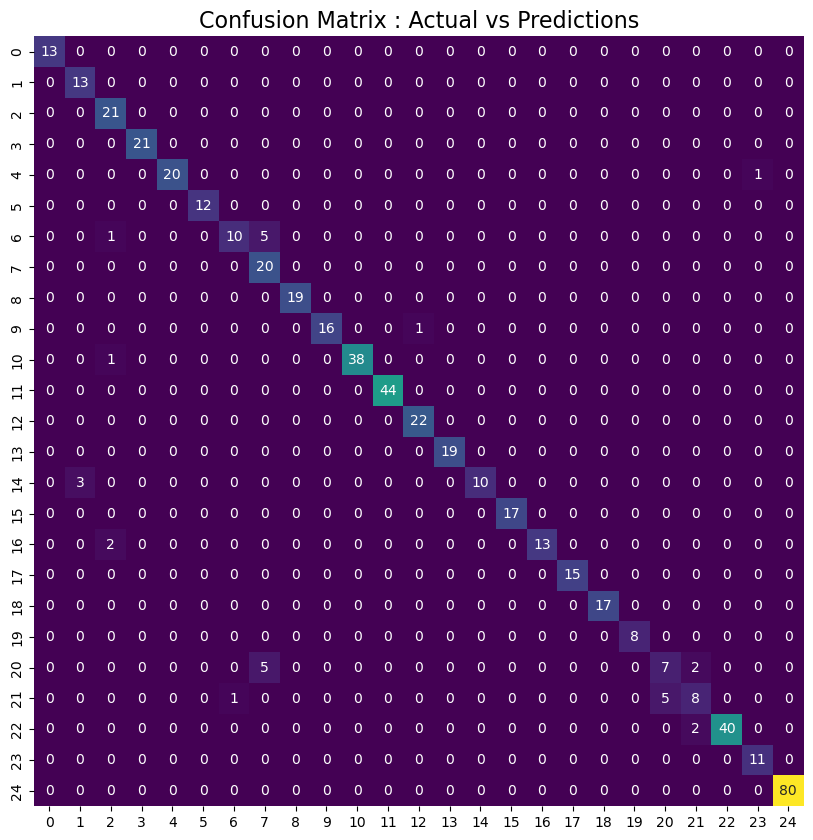

In [76]:
plot_confusion(actual_test_values, rounded_predictions_less)

In [77]:
print(classification_report(actual_test_values, rounded_predictions_less, target_names=class_names))

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       0.81      1.00      0.90        13
     Allaple.A       0.84      1.00      0.91        21
     Allaple.L       1.00      1.00      1.00        21
 Alueron.gen!J       1.00      0.95      0.98        21
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       0.91      0.62      0.74        16
   C2LOP.gen!g       0.67      1.00      0.80        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       1.00      0.94      0.97        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       0.96      1.00      0.98        22
    Lolyda.AA2       1.00      1.00      1.00        19
    Lolyda.AA3       1.00      0.77      0.87        13
     Lolyda.AT       1.00      1.00      1.00        17
   Malex.gen!J       1.00      0.87      0.93  

# 3.3 PRE-TRAINED ARCHITECTURES

Universally most award winning pre-trained architectures are built using RGB and not greyscale images. Hence we will need to rescale our images to ensure we are also using the same.

Inspiration from using pre-trained models comes from thesis and taken idas from: https://www.kaggle.com/code/gvyshnya/malimg-coatnet-model , though I didn't explicity use there work as they did CoatNet. 

Also inspiration from: https://www.kaggle.com/code/gauravpendharkar/malware-classification#Model-Exploration-on-the-three-datasets on how to use pretrined models with Malimg dataset

In [79]:
training_pretrained = ImageDataGenerator().flow_from_directory(directory=training_dataset, target_size=(128,128), batch_size=64, color_mode="rgb", class_mode ='categorical')
validation_pretrained = ImageDataGenerator().flow_from_directory(directory=val, target_size=(128,128), batch_size=64, color_mode="rgb", class_mode ='categorical')
testing_pretrained = ImageDataGenerator().flow_from_directory(directory=test, target_size=(128,128), batch_size=64, color_mode="rgb", class_mode ='categorical')

x_test_pretrained, y_test_pretrained = create_DataArray(testing_pretrained) #reinitialise numpy array with RGB that will be used for result visualisations


Found 4160 images belonging to 25 classes.
Found 510 images belonging to 25 classes.
Found 543 images belonging to 25 classes.


**VGG-16**

In [80]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
#utlising pretrained weights from imagenet 

pre_trained_VGG = Sequential()

pre_trained_VGG.add(vgg_model)
pre_trained_VGG.add(Flatten())
pre_trained_VGG.add(Dense(128, activation='relu'))
pre_trained_VGG.add(Dropout(0.25))
pre_trained_VGG.add(Dense(25, activation='softmax'))
pre_trained_VGG.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 25)                3225      
                                                                 
Total params: 15,766,617
Trainable params: 15,766,617
Non-trainable params: 0
___________________________________________

In [82]:
pre_trained_VGG.compile(keras.optimizers.Adam(lr=0.001) ,loss='categorical_crossentropy', metrics=['accuracy'])

VGG_call = callbacks("pretrainedVGG")


VGG16_model = pre_trained_VGG.fit(training_pretrained, validation_data=validation_pretrained, 
                    epochs=10, batch_size=64, callbacks=VGG_call)

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8978
Epoch 1: val_accuracy improved from -inf to 0.93137, saving model to pretrainedVGG
65/65 [==============================] - 38s 470ms/step - loss: 0.3402 - accuracy: 0.8978 - val_loss: 0.1965 - val_accuracy: 0.9314
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.9149
Epoch 2: val_accuracy did not improve from 0.93137
65/65 [==============================] - 25s 383ms/step - loss: 0.2715 - accuracy: 0.9149 - val_loss: 0.2957 - val_accuracy: 0.9039
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 1.0421 - accuracy: 0.8627
Epoch 3: val_accuracy did not improve from 0.93137
65/65 [==============================] - 25s 388ms/step - loss: 1.0421 - accuracy: 0.8627 - val_loss: 0.2839 - val_accuracy: 0.9157
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.9202
Epoch 4: val_accuracy did not improve from 

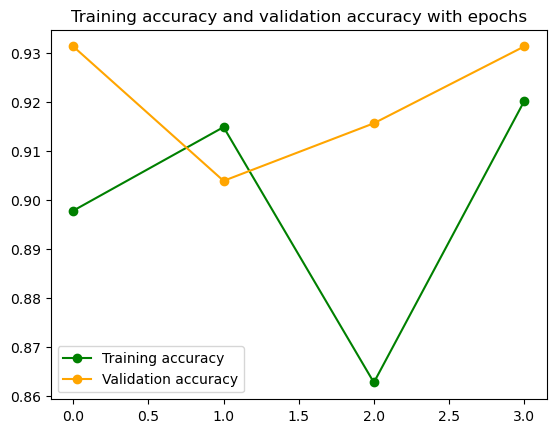

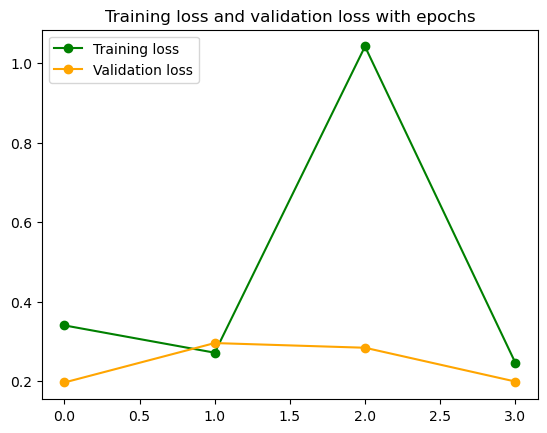

In [83]:
plot_loss_and_accuracy_training(VGG16_model)

In [85]:
prediction_vgg = pre_trained_VGG.predict(x_test_pretrained, batch_size=64, verbose=2)

test_loss, test_acc = pre_trained_VGG.evaluate(testing_pretrained, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

9/9 - 3s - 3s/epoch - 289ms/step
50/50 [==============================] - 3s 54ms/step - loss: 0.1954 - accuracy: 0.9411
Test Accuracy: 94.11 %
Test Loss: 0.19536186754703522


In [86]:
rounded_predictions_vgg = np.argmax(prediction_vgg, axis=1)
actual_test_values_rgb = np.argmax(y_test_pretrained, axis=1)

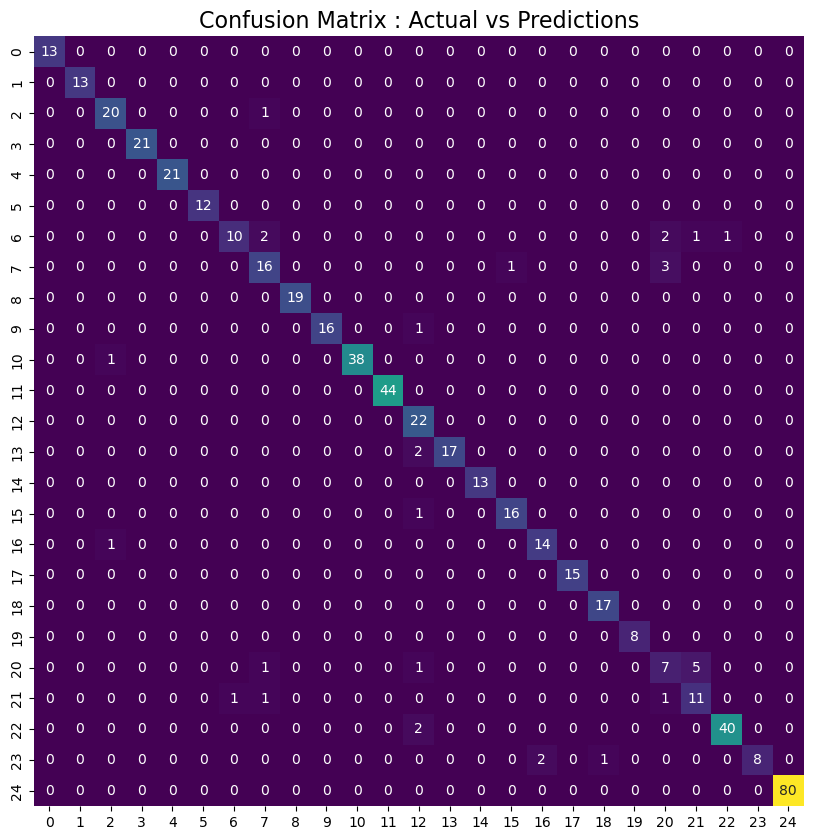

In [87]:
plot_confusion(actual_test_values_rgb, rounded_predictions_vgg)

In [89]:
print(classification_report(actual_test_values_rgb, rounded_predictions_vgg, target_names=class_names))

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       1.00      1.00      1.00        13
     Allaple.A       0.91      0.95      0.93        21
     Allaple.L       1.00      1.00      1.00        21
 Alueron.gen!J       1.00      1.00      1.00        21
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       0.91      0.62      0.74        16
   C2LOP.gen!g       0.76      0.80      0.78        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       1.00      0.94      0.97        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       0.76      1.00      0.86        22
    Lolyda.AA2       1.00      0.89      0.94        19
    Lolyda.AA3       1.00      1.00      1.00        13
     Lolyda.AT       0.94      0.94      0.94        17
   Malex.gen!J       0.88      0.93      0.90  

**ResNet 50**

In [105]:
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

pre_trained_Res = Sequential()

pre_trained_Res.add(res_model)
pre_trained_Res.add(Flatten())
pre_trained_Res.add(Dense(128, activation='relu'))
pre_trained_Res.add(Dropout(0.25))
pre_trained_Res.add(Dense(25, activation='softmax'))
pre_trained_Res.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 25)                3225      
                                                                 
Total params: 27,785,369
Trainable params: 27,732,249
Non-trainable params: 53,120
_________________________________________________________________


In [106]:
pre_trained_Res.compile(keras.optimizers.Adam(lr=0.001) ,loss='categorical_crossentropy', metrics=['accuracy'])

Res_call = callbacks("pretrainedResNet")

ResNet_model = pre_trained_Res.fit(training_pretrained, validation_data=validation_pretrained, 
                    epochs=10, batch_size=64, callbacks=Res_call)

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 1.6569 - accuracy: 0.8108
Epoch 1: val_accuracy improved from -inf to 0.01373, saving model to pretrainedResNet
65/65 [==============================] - 122s 1s/step - loss: 1.6569 - accuracy: 0.8108 - val_loss: 6458955.0000 - val_accuracy: 0.0137
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9185
Epoch 2: val_accuracy improved from 0.01373 to 0.10000, saving model to pretrainedResNet
65/65 [==============================] - 65s 1s/step - loss: 0.2770 - accuracy: 0.9185 - val_loss: 1287.6376 - val_accuracy: 0.1000
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.9236
Epoch 3: val_accuracy did not improve from 0.10000
65/65 [==============================] - 27s 418ms/step - loss: 0.4430 - accuracy: 0.9236 - val_loss: 17038.0391 - val_accuracy: 0.0784
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0

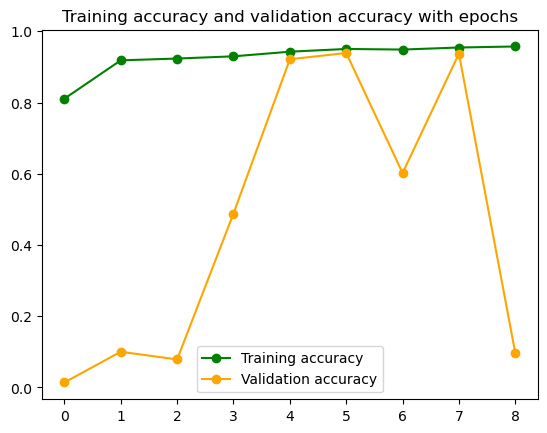

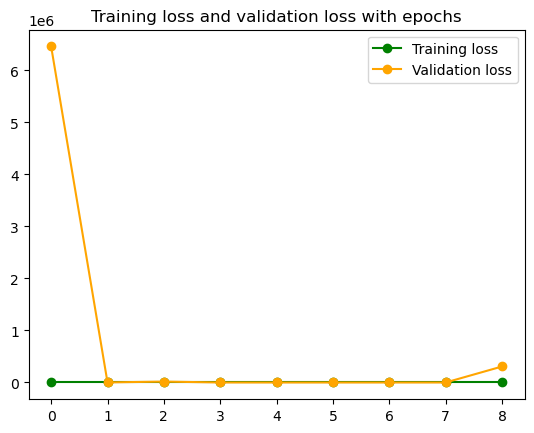

In [109]:
plot_loss_and_accuracy_training(ResNet_model)

In [110]:
prediction_res = pre_trained_Res.predict(x_test_pretrained, batch_size=64, verbose=2)

test_loss, test_acc = pre_trained_Res.evaluate(testing_pretrained, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

9/9 - 2s - 2s/epoch - 260ms/step
50/50 [==============================] - 3s 45ms/step - loss: 0.2048 - accuracy: 0.9392
Test Accuracy: 93.92 %
Test Loss: 0.2047548145055771


In [111]:
rounded_predictions_res = np.argmax(prediction_res, axis=1)


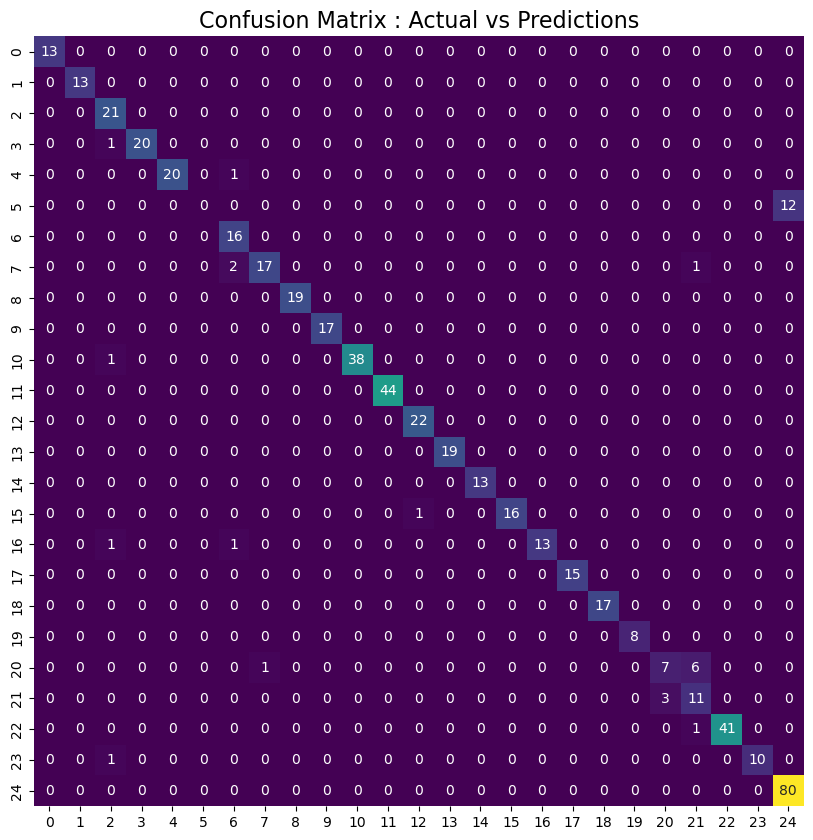

In [116]:
plot_confusion(actual_test_values_rgb, rounded_predictions_res)

In [115]:
print(classification_report(actual_test_values_rgb, rounded_predictions_res, target_names=class_names))

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       1.00      1.00      1.00        13
     Allaple.A       0.84      1.00      0.91        21
     Allaple.L       1.00      0.95      0.98        21
 Alueron.gen!J       1.00      0.95      0.98        21
     Autorun.K       0.00      0.00      0.00        12
       C2LOP.P       0.80      1.00      0.89        16
   C2LOP.gen!g       0.94      0.85      0.89        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       1.00      1.00      1.00        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       0.96      1.00      0.98        22
    Lolyda.AA2       1.00      1.00      1.00        19
    Lolyda.AA3       1.00      1.00      1.00        13
     Lolyda.AT       1.00      0.94      0.97        17
   Malex.gen!J       1.00      0.87      0.93  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# References

the neural network wouldn't have been possible without some libraries and packages used to create our Neural Network. moreover some previous work under the Apache 2 license was also utilised for the visualisation of results.

Down below are some reference for the nueral network. Though many resoruces from Kaggle were used and Kaggle Forums helped alot with many errors I got throughout the code :) 

[1] Team, K. (n.d.). Keras Documentation: The sequential class. Keras. https://keras.io/api/models/sequential/ 

[2] 3.3. metrics and scoring: Quantifying the quality of predictions. scikit. (n.d.). https://scikit-learn.org/stable/modules/model_evaluation.html 

[3] Gauravpendharkar. (2023, March 31). Malware classification. Kaggle. https://www.kaggle.com/code/gauravpendharkar/malware-classification 

[4] Mhmdsyed. (2023, March 3). Malware CNN: Image classification. Kaggle. https://www.kaggle.com/code/mhmdsyed/malware-cnn-image-classification/notebook 

[5] Gvyshnya. (2023, March 24). MALIMG Coatnet Model. Kaggle. https://www.kaggle.com/code/gvyshnya/malimg-coatnet-model 